# GBDTs.jl -- Grammar-Based Decision Trees

Grammar-based decision tree (GBDT) is an interpretable machine learning model that can be used for the classification and categorization of heterogeneous multivariate time series data.  GBDTs combine decision trees with a grammar framework.  Each split of the decision tree is governed by a logical expression derived from a user-supplied grammar.  The flexibility of the grammar framework enables GBDTs to be applied to a wide range of problems.  In particular, GBDT has been previously applied to analyze multivariate heterogeneous time series data of failures in aircraft collision avoidance systems [1].

[1] Lee et al. "Interpretable Categorization of Heterogeneous Time Series Data", preprint, 2018.

GBDTs.jl depends on ExprOptimization.jl for optimizing the expressions at each node.

To install the package:

    Pkg.clone("https://github.com/sisl/GBDTs.jl")
    
To get started:

In [1]:
using GBDTs

## Australian Sign Language (Auslan) Dataset Example

We analyze a subset of the Australian Sign Language dataset from the UCI Repository as an example.  The dataset contains 8 words (labels): hello, please, yes, no, right wrong, same, different.

Load the labeled dataset from file:
(Hint: if you unzip the data file to a directory of the same name, it'll load much faster)

In [2]:
using MultivariateTimeSeries
X, y = read_data_labeled(joinpath(dirname(pathof(GBDTs)), "..", "data", "auslan_youtube8"));

### Define a grammar

Here we use a simple grammar based on temporal logic:

In [3]:
grammar = @grammar begin
    b = G(bvec) | F(bvec) | G(implies(bvec,bvec))
    bvec = and(bvec, bvec)
    bvec = or(bvec, bvec)
    bvec = not(bvec)
    bvec = lt(rvec, rvec)
    bvec = lte(rvec, rvec)
    bvec = gt(rvec, rvec)
    bvec = gte(rvec, rvec)
    bvec = f_lt(x, xid, v, vid)
    bvec = f_lte(x, xid, v, vid)
    bvec = f_gt(x, xid, v, vid)
    bvec = f_gte(x, xid, v, vid)
    rvec = x[!,xid]
    xid = |([:x_1,:y_1,:z_1,:roll_1,:pitch_1,:yaw_1,:thumbbend_1,:forebend_1,:middlebend_1,:ringbend_1,:littlebend_1,:x_2,:y_2,:z_2,:roll_2,:pitch_2,:yaw_2,:thumbbend_2,:forebend_2,:middlebend_2,:ringbend_2,:littlebend_2])
    vid = |(1:10)
end

1: b = G(bvec)
2: b = F(bvec)
3: b = G(implies(bvec, bvec))
4: bvec = and(bvec, bvec)
5: bvec = or(bvec, bvec)
6: bvec = not(bvec)
7: bvec = lt(rvec, rvec)
8: bvec = lte(rvec, rvec)
9: bvec = gt(rvec, rvec)
10: bvec = gte(rvec, rvec)
11: bvec = f_lt(x, xid, v, vid)
12: bvec = f_lte(x, xid, v, vid)
13: bvec = f_gt(x, xid, v, vid)
14: bvec = f_gte(x, xid, v, vid)
15: rvec = x[!, xid]
16: xid = :x_1
17: xid = :y_1
18: xid = :z_1
19: xid = :roll_1
20: xid = :pitch_1
21: xid = :yaw_1
22: xid = :thumbbend_1
23: xid = :forebend_1
24: xid = :middlebend_1
25: xid = :ringbend_1
26: xid = :littlebend_1
27: xid = :x_2
28: xid = :y_2
29: xid = :z_2
30: xid = :roll_2
31: xid = :pitch_2
32: xid = :yaw_2
33: xid = :thumbbend_2
34: xid = :forebend_2
35: xid = :middlebend_2
36: xid = :ringbend_2
37: xid = :littlebend_2
38: vid = 1
39: vid = 2
40: vid = 3
41: vid = 4
42: vid = 5
43: vid = 6
44: vid = 7
45: vid = 8
46: vid = 9
47: vid = 10


Define the functions used in the grammar:

In [4]:
G(v) = all(v)                                                #globally
F(v) = any(v)                                                #eventually
f_lt(x, xid, v, vid) = lt(x[!,xid], v[xid][vid])               #feature is less than a constant
f_lte(x, xid, v, vid) = lte(x[!,xid], v[xid][vid])             #feature is less than or equal to a constant
f_gt(x, xid, v, vid) = gt(x[!,xid], v[xid][vid])               #feature is greater than a constant
f_gte(x, xid, v, vid) = gte(x[!,xid], v[xid][vid])             #feature is greater than or equal to a constant

#workarounds for slow dot operators:
implies(v1, v2) = (a = similar(v1); a .= v2 .| .!v1)         #implies
not(v) = (a = similar(v); a .= .!v)                          #not
and(v1, v2) = (a = similar(v1); a .= v1 .& v2)               #and
or(v1, v2) = (a = similar(v1); a .= v1 .| v2)                #or
lt(x1, x2) = (a = Vector{Bool}(undef,length(x1)); a .= x1 .< x2)   #less than
lte(x1, x2) = (a = Vector{Bool}(undef,length(x1)); a .= x1 .≤ x2)  #less than or equal to
gt(x1, x2) = (a = Vector{Bool}(undef,length(x1)); a .= x1 .> x2)   #greater than
gte(x1, x2) = (a = Vector{Bool}(undef,length(x1)); a .= x1 .≥ x2)  #greater than or equal to

gte (generic function with 1 method)

We'll specify the constants in the grammar by discretizing uniformly per feature:

In [5]:
const v = Dict{Symbol,Vector{Float64}}()
mins, maxes = minimum(X), maximum(X)
for (i,xid) in enumerate(Symbol.(names(X)))
    v[xid] = collect(range(mins[i],stop=maxes[i],length=10))
end;

### Learn a GBDT from data

GBDT uses ExprOptimization to optimize each split.  A number of optimization algorithms are available (see ExprOptimization.jl).

Specify the search parameters for the optimization:

In [6]:
p = MonteCarlo(2000, 5)

MonteCarlo(2000, 5, ExprOptimization.MonteCarlos.NoTracking())

Learn the GBDT:

In [7]:
using Random; Random.seed!(1)
model = induce_tree(grammar, :b, p, X, y, 6);

### Visualize the tree

Using TikzGraphs:

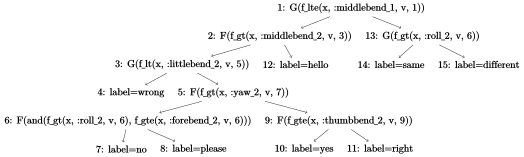

In [8]:
display(model; edgelabels=false) #suppress edge labels for clarity (left branch is true, right branch is false)

Using AbstractTrees:

In [9]:
show(model)

1: label=1, loss=75.4, G(f_lte(x, :middlebend_1, v, 1))
├─ 2: label=1, loss=67.07, F(f_gt(x, :middlebend_2, v, 3))
│  ├─ 3: label=2, loss=60.4, G(f_lt(x, :littlebend_2, v, 5))
│  │  ├─ 4: label=6
│  │  └─ 5: label=2, loss=50.4, F(f_gt(x, :yaw_2, v, 7))
│  │     ├─ 6: label=2, loss=0.8, F(and(f_gt(x, :roll_2, v, 6), f_gte(x, :forebend_2, v, 6)))
│  │     │  ├─ 7: label=4
│  │     │  │  ⋮
│  │     │  │  
│  │     │  └─ 8: label=2
│  │     │     ⋮
│  │     │     
│  │     └─ 9: label=3, loss=0.4, F(f_gte(x, :thumbbend_2, v, 9))
│  │        ├─ 10: label=3
│  │        │  ⋮
│  │        │  
│  │        └─ 11: label=5
│  │           ⋮
│  │           
│  └─ 12: label=1
└─ 13: label=7, loss=0.4, G(f_gt(x, :roll_2, v, 6))
   ├─ 14: label=7
   └─ 15: label=8


### Use the GBDT model for prediction

Here, we'll predict the training data and evaluate the accuracy.

In [10]:
ind = collect(1:length(X))
y_pred = classify(model, X, ind)
accuracy = count(y_pred .== y[ind]) / length(ind)

1.0

### Determine the members of each node

In [11]:
mvec = node_members(model, X, ind)
mvec[3]' #members of node 3

1×135 adjoint(::Vector{Int64}) with eltype Int64:
 28  29  30  31  32  33  34  35  36  37  …  156  157  158  159  160  161  162